## measuring memory latency 

In this notebook we will investigate the distribution of latency times for different size arrays.

1. **Goal 1:** Measure the effects of caching **in the wild**
2. **Goal 2:** Undestand how to study long-tail distributions.

## Collecting System Description
In this section you will find commands that list properties of the hardware you are using.

We recommend that you run the notebook on your notebook to measure the latencies on your computer.

**Please Note:** There are cells marked to be run by specific OS users. So, for those cells, run only the ones for the OS you are using. For example, if you are a windows OS user, then run only "Collecting System Description: For Windows  users ONLY" and not other cells.

### Are you using a Virtual Machine?
If you are, Uncomment the following code so that `isVM` is set to `["True"]`

In [1]:
isVM = ["False"]
#isVM = ["True"]

### Specify which OS you are using
Uncomment the line corresponding to your OS. Comment all of the rest.

In [2]:
brand_name = ["brand: Macbook"]
#brand_name = ["brand: Linux"]
#brand_name = ["brand: Windows"]

### For Mac users

The next cell needs to be run only by Mac OS users. If run on other OS platforms, it will throw error. 

In [3]:
# To get all available information use !sysctl -a
if brand_name[0] == "brand: Macbook":
    os_info = !sysctl kernel.osrelease kernel.osrevision kernel.ostype kernel.osversion
    cpu_info = !sysctl machdep.cpu.brand_string machdep.cpu.cache.L2_associativity machdep.cpu.cache.linesize machdep.cpu.cache.size machdep.cpu.core_count
    cache_info = !sysctl kern.procname hw.memsize hw.cpufamily hw.activecpu hw.cachelinesize hw.cpufrequency hw.l1dcachesize hw.l1icachesize hw.l2cachesize hw.l3cachesize hw.cputype 

### For Linux OS users

The next cell needs to be run only by Linux OS users. If run on other OS platforms, it will throw error.

In [4]:
if brand_name[0] == "brand: Linux":
    os_info = !sysctl kernel.ostype kernel.osrelease 
    os_version = !lsb_release -r
    memory_size = !cat /proc/meminfo | grep 'MemTotal'
    os_info += os_version + memory_size

    cache_L1i = !lscpu | grep 'L1i'
    cache_L1d = !lscpu | grep 'L1d'
    cache_L2 = !lscpu | grep 'L2'
    cache_L3 = !lscpu | grep 'L3'
    cache_info = cache_L1i + cache_L1d + cache_L2 + cache_L3

    cpu_type = !lscpu | grep 'CPU family'
    cpu_brand = !cat /proc/cpuinfo | grep -m 1 'model name'
    cpu_frequency = !lscpu | grep 'CPU MHz'
    cpu_core_count = !lscpu | grep 'CPU(s)'
    cpu_info = cpu_type + cpu_brand + cpu_frequency + cpu_core_count



###  For Windows users
The next cell needs to be run only by Windows OS users. If run on other OS platforms, it will throw error.

In [5]:
if brand_name[0] =="brand: Windows":
    os_release  = !ver
    os_type     = !WMIC CPU get  SystemCreationClassName
    memory      = !WMIC ComputerSystem get TotalPhysicalMemory
    os_info     = os_release + os_type

    cpu_core_count  = !WMIC CPU get NumberOfCores
    cpu_speed       = !WMIC CPU get CurrentClockSpeed
    cpu_model_name  = !WMIC CPU get name
    cpu_info        = cpu_core_count + cpu_speed + cpu_model_name

    l2cachesize = !WMIC CPU get L2CacheSize
    l3cachesize = !WMIC CPU get L3CacheSize
    cache_info  = l2cachesize + l3cachesize


In [6]:
# Print collected information
description= ['Virtual Machine :'+isVM[0]]+ brand_name + os_info + cache_info + cpu_info
print("Main Harware Parameters:\n")
print('\n'.join(description))

Main Harware Parameters:

Virtual Machine :False
brand: Macbook
sysctl: unknown oid 'kernel.osrelease'
kern.procname: sysctl
hw.memsize: 17179869184
hw.cpufamily: 280134364
hw.activecpu: 8
hw.cachelinesize: 64
hw.cpufrequency: 2500000000
hw.l1dcachesize: 32768
hw.l1icachesize: 32768
hw.l2cachesize: 262144
hw.l3cachesize: 6291456
hw.cputype: 7
machdep.cpu.brand_string: Intel(R) Core(TM) i7-4870HQ CPU @ 2.50GHz
machdep.cpu.cache.L2_associativity: 8
machdep.cpu.cache.linesize: 64
machdep.cpu.cache.size: 256
machdep.cpu.core_count: 4


### Summary of  Macbook Pro hardware parameters
###  Intel four cores
###  Clock Rate: `2.50GHz` (0.4ns per clock cycle)
<img alt="" src="Figures/MacBookProMemorySizes.png" style="width:500px" />

### Import modules

In [7]:
# Enable automatic reload of libraries
%load_ext autoreload
%autoreload 2 # means that all modules are reloaded before every command

%pylab inline
from numpy import *

Populating the interactive namespace from numpy and matplotlib


In [8]:
import time
from matplotlib.backends.backend_pdf import PdfPages

from os.path import isfile,isdir
from os import mkdir
import os

#### Set log directory
This script generates large files. We put these files in a separate directory so it is easier to delete them later.

#run this cell only once

In [9]:
## Remember the path for the log directory
log_root,=!pwd
log_root+='/logs'
log_root
if not isdir(log_root):
    mkdir(log_root)

In [10]:
import sys
sys.path.append('./lib')
from measureRandomAccess import measureRandomAccess
from PlotTime import PlotTime
from create_file import create_file,tee

### defining memory latency
Latency is the time difference between the time at which the CPU is issuing a read or write command and, the time the command is complete.

* This time is  very short if the element is already in the L1 Cache, 

* and is very long if the element is in external memory (disk or SSD).

### setting parameters
* We test access to elements arrays whose sizes are:
   * `m_legend=['Zero','1KB','1MB','1GB','10GB']`
* Arrays are stored **in memory** or **on disk**

* We perform 100,000 read/write ops  to random locations in the array.
* We analyze the **distribution** of the latencies as a function of the size of the array.

In [11]:
m_list=[0]+[int(10**i) for i in [3,6,9,10]]
m_legend=['Zero','1KB','1MB','1GB','10GB']
L=len(m_list)
k=100000 # number of pokes
print('m_list=',m_list)

m_list= [0, 1000, 1000000, 1000000000, 10000000000]


### Set working directory
This script generates large files. We put these files in a separate directory so it is easier to delete them later.

In [12]:
TimeStamp=str(int(time.time()))
log_dir=log_root+'/'+TimeStamp
mkdir(log_dir)
%cd $log_dir
stat=open('stats.txt','w')

def tee(line):
    print(line)
    stat.write(line+'\n')

/Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Section1-Basics/0.MemoryLatency/logs/1520883359


In [13]:
_mean=zeros([2,L])   #0: using disk, 1: using memory
_std=zeros([2,L])
_block_no=zeros([L])
_block_size=zeros([L])
T=zeros([2,L,k])

In [14]:
Random_pokes=[]
Min_Block_size=1000000
for m_i in range(len(m_list)):
    
    m=m_list[m_i]
    blocks=int(m/Min_Block_size)
    if blocks==0:
        _block_size[m_i]=1
        _block_no[m_i]=m
    else:
        _block_size[m_i]=Min_Block_size
        _block_no[m_i]=blocks
    (t_mem,t_disk) = create_file(int(_block_size[m_i]),int(_block_no[m_i]),filename='BlockData'+str(m))

    (_mean[0,m_i],_std[0,m_i],T[0,m_i]) = measureRandomAccess(m,filename='BlockData'+str(m),k=k)
    T[0,m_i]=sorted(T[0,m_i])
    tee('\rFile pokes _mean='+str(_mean[0,m_i])+', file _std='+str(_std[0,m_i]))

    (_mean[1,m_i],_std[1,m_i],T[1,m_i]) = measureRandomAccess(m,filename='',k=k)
    T[1,m_i]=sorted(T[1,m_i])
    tee('\rMemory pokes _mean='+str(_mean[1,m_i])+', Memory _std='+str(_std[1,m_i]))
    
    Random_pokes.append({'m_i':m_i,
                        'm':m,
                        'memory__mean': _mean[1,m_i],
                        'memory__std': _std[1,m_i],
                        'memory_largest': T[1,m_i][-1000:],
                        'file__mean': _mean[0,m_i],
                        'file__std': _std[0,m_i],
                        'file_largest': T[0,m_i][-1000:]                
                })
print('='*50)

              
creating 1 byte block: 0.000002 sec, writing 0 blocks 0.000241 sec
File pokes _mean=1.02474689484e-07, file _std=3.61182772748e-07
Memory pokes _mean=9.95993614197e-08, Memory _std=3.21903485859e-07
              
creating 1 byte block: 0.000002 sec, writing 1000 blocks 0.004387 sec
File pokes _mean=1.84114527702e-05, file _std=6.71231330072e-06
Memory pokes _mean=1.65102481842e-07, Memory _std=4.06086937397e-07
              
creating 1000000 byte block: 0.000095 sec, writing 1 blocks 0.004936 sec
File pokes _mean=2.05693507195e-05, file _std=8.03192722287e-06
Memory pokes _mean=2.31082439423e-07, Memory _std=4.72921939948e-07
              
creating 1000000 byte block: 0.000037 sec, writing 1000 blocks 0.893313 sec
File pokes _mean=5.06786179543e-05, file _std=0.000535908498419
Memory pokes _mean=3.36697101593e-07, Memory _std=5.56007917684e-07
              
creating 1000000 byte block: 0.000043 sec, writing 10000 blocks 9.067786 sec
File pokes _mean=0.000124714007378

In [15]:
fields=['m', 'memory__mean', 'memory__std','file__mean','file__std']
print('| block size | mem mean  | mem std | disk mean | disk std |')
print('| :--------- | :----------- | :--- | :-------- | :------- |')
for R in Random_pokes:
    tup=tuple([R[f] for f in fields])
    print('| %d | %6.3g | %6.3g |  %6.3g | %6.3g |'%tup)

| block size | mem mean  | mem std | disk mean | disk std |
| :--------- | :----------- | :--- | :-------- | :------- |
| 0 | 9.96e-08 | 3.22e-07 |  1.02e-07 | 3.61e-07 |
| 1000 | 1.65e-07 | 4.06e-07 |  1.84e-05 | 6.71e-06 |
| 1000000 | 2.31e-07 | 4.73e-07 |  2.06e-05 | 8.03e-06 |
| 1000000000 | 3.37e-07 | 5.56e-07 |  5.07e-05 | 0.000536 |
| 10000000000 | 2.72e-06 | 9.38e-06 |  0.000125 | 0.000201 |


### Mean and std of latency for random access
<img alt="" src="Figures/Random_access_latency.png" style="width:700px" />
* Note that `zero` is not really zero.
* system time is accurate to micro-second, not nano-second.
* SSD random access latency is $10^{-5} - 10^{-4}$

### Digging deeper
* THe mean and std are the first statistics to look at.
* but the distribution might have more to tell us.

### First, lets try histograms

Disk Block of size 1e+01 GB
 latency mean=2.72224664688e-06,  std=9.37550414348e-06
 Fraction of zeros= 0.28836


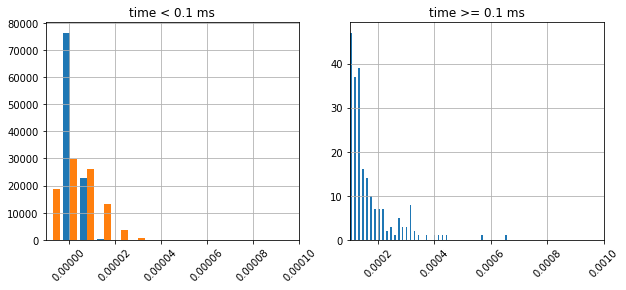

In [16]:
m_i=4
Disk_Mem=1
print('Disk Block of size %2.1g GB'%(m_list[m_i]/1e9))
print('\r latency mean='+str(_mean[1,m_i])+',  std='+str(_std[1,m_i]))

_mean_t=_mean[Disk_Mem,m_i]
_std_t=_std[Disk_Mem,m_i]
_normal=random.normal(loc=_mean_t,scale=_std_t,size=T.shape[2])
tmp=T[Disk_Mem,m_i]
print(' Fraction of zeros=',sum(tmp==0)/len(tmp))
figure(figsize=(10,4))
subplot(121)
thr=1e-4
hist([tmp[tmp<thr],_normal[_normal<thr]],bins=20);
#ylim([0,20000])
xlim([-thr/10,thr])
title('time < %3.2g ms'%(thr*1e3))
xticks(rotation=45)
grid()
subplot(122)
hist([tmp[tmp>=thr],_normal[_normal>=thr]],bins=40);
xlim([thr,thr*10])
#ylim([0,20])
title('time >= %3.2g ms'%(thr*1e3))
xticks(rotation=45);
grid();

### CDF instead of histogram

* Choosing ranges and bin-numbers for histograms can be hard.

* $CDF(a) = Pr(T\leq a)$ . . . . . . . .($T$=latency)

* Plotting a CDF does not require choosing bins.

* We are interested in larger latencies, so we use instead
$$1-CDF(a) = 1-Pr(T\leq a) = Pr(T>a)$$

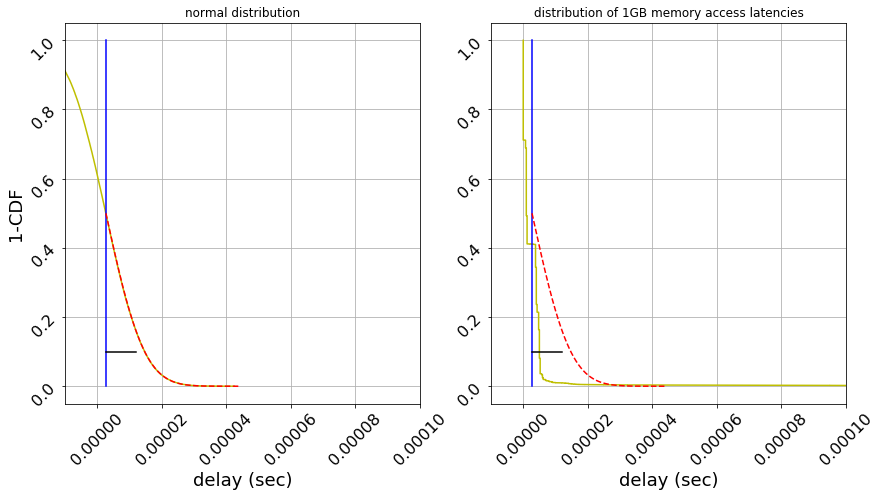

In [17]:
figure(figsize=(14,7))
subplot(121)
grid()
PlotTime(sort(_normal),_mean_t,_std_t,Color=['y','b','k','r'],LS=['-','-','-','--'],LogLog=False)
title('normal distribution')
xlabel('delay (sec)',fontsize=18)
xlim([-thr/10,thr])
ylabel('1-CDF',fontsize=18)
tick_params(axis='both', which='major', labelsize=16,rotation=45)
tick_params(axis='both', which='minor', labelsize=12,rotation=45)

#print('%d Memory Blocks of size %d bytes'%(m_list[m_i],n))
#print('\rMemory pokes _mean='+str(_mean[1,m_i])+', Memory _std='+str(_std[1,m_i]))
subplot(122)
grid()
PlotTime(sort(tmp),_mean_t,_std_t,Color=['y','b','k','r'],LS=['-','-','-','--'],LogLog=False)
title('distribution of 1GB memory access latencies')
xlabel('delay (sec)',fontsize=18)
xlim([-thr/10,thr])
#ylim([0,0.001])
#ylabel('1-CDF',fontsize=18)
tick_params(axis='both', which='major', labelsize=16,rotation=45)
tick_params(axis='both', which='minor', labelsize=12,rotation=45)

### CDF + loglog plots

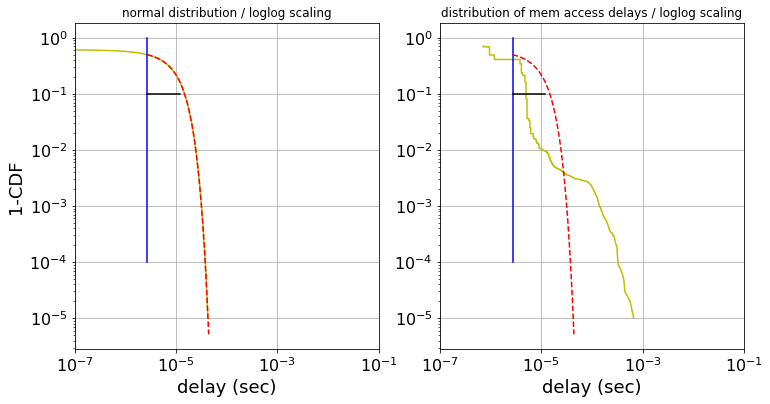

In [18]:
figure(figsize=(12,6))
subplot(121)
grid()
PlotTime(sort(_normal),_mean_t,_std_t,Color=['y','b','k','r'],LS=['-','-','-','--'])
title('normal distribution / loglog scaling')
xlabel('delay (sec)',fontsize=18)
xlim([1e-7,1000*thr])
ylabel('1-CDF',fontsize=18)
tick_params(axis='both', which='major', labelsize=16)
tick_params(axis='both', which='minor', labelsize=12)

#print('%d Memory Blocks of size %d bytes'%(m_list[m_i],n))
#print('\rMemory pokes _mean='+str(_mean[1,m_i])+', Memory _std='+str(_std[1,m_i]))
subplot(122)
grid()
PlotTime(sort(tmp),_mean_t,_std_t,Color=['y','b','k','r'],LS=['-','-','-','--'])
title('distribution of mem access delays / loglog scaling')
xlabel('delay (sec)',fontsize=18)
xlim([1e-7,1000*thr])
#ylabel('1-CDF',fontsize=18)
tick_params(axis='both', which='major', labelsize=16)
tick_params(axis='both', which='minor', labelsize=12)

### Characterize random access to storage

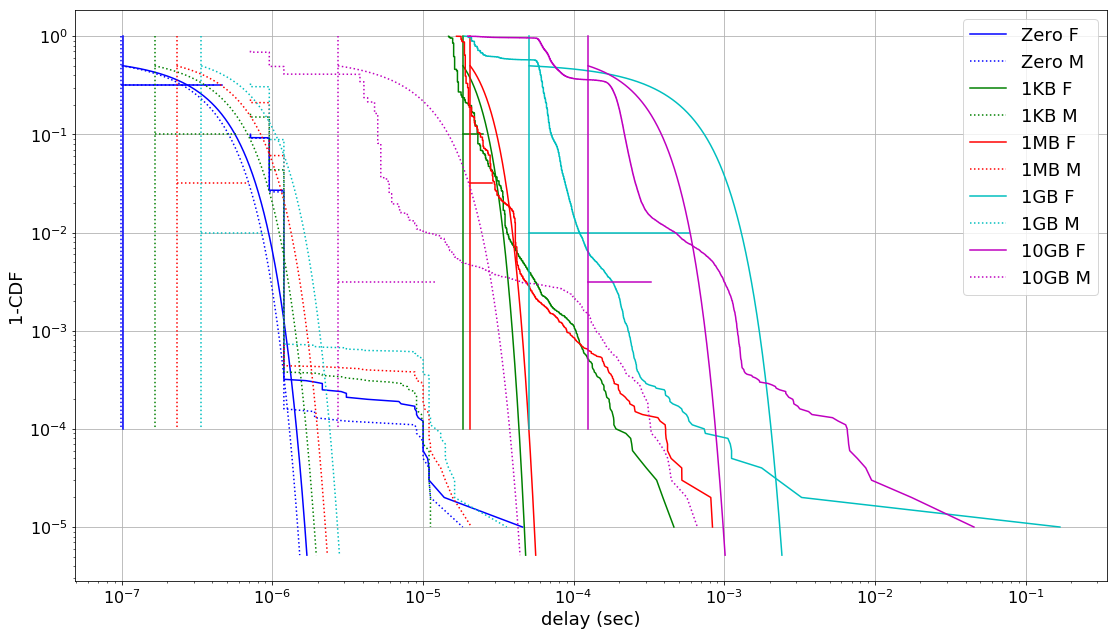

In [19]:
pp = PdfPages('MemoryFigure.pdf')
figure(figsize=(6,4))

Colors='bgrcmyk'  # The colors for the plot
LineStyles=['-',':']
Legends=['F','M']

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5,10.5)

for m_i in range(len(m_list)):
    Color=Colors[m_i % len(Colors)]
    for Type in [0,1]:
        
        PlotTime(sort(T[Type,m_i]),_mean[Type,m_i],_std[Type,m_i],\
             Color=Color,LS=LineStyles[Type],Legend=m_legend[m_i]+' '+Legends[Type],\
             m_i=m_i)

grid()
legend(fontsize=18)
xlabel('delay (sec)',fontsize=18)
ylabel('1-CDF',fontsize=18)
tick_params(axis='both', which='major', labelsize=16)
tick_params(axis='both', which='minor', labelsize=12)
pp.savefig()
pp.close()

### Characterize sequential access

* Random access degrades rapidly with the size of the block.
* Sequential access  is **much** faster.
* We already saw that writing 10GB to disk sequentially takes 8.9sec, or less than 1 second for a gigbyte.
* Writing a 1TB disk at this rate would take ~1000 seconds or about 16 minutes.

In [20]:
import time
Consec=[]
Line='### Consecutive Memory writes:'
print(Line); stat.write(Line+'\n')
n=1000
r=np.array(list(range(n)))
Header="""
|   size (MB) | Average time per byte |
| ---------: | --------------: | """
tee(Header)
for m in [1,1000,1000000,10000000]:
    t1=time.time()
    A=np.repeat(r,m)
    t2=time.time()
    Consec.append((n,m,float(n*m)/1000000,(t2-t1)/float(n*m)))
    tee("| %6.3f | %4.2g |" % (float(n*m)/1000000,(t2-t1)/float(n*m)))
A=[];r=[]
stat.close()

### Consecutive Memory writes:

|   size (MB) | Average time per byte |
| ---------: | --------------: | 
|  0.001 | 2.2e-08 |
|  1.000 | 6.8e-09 |
| 1000.000 | 7.4e-09 |
| 10000.000 | 9.5e-09 |


### Consecutive Memory writes:

<img alt="" src="Figures/Sequential_access_latency.png" style="width:500px" />

* We are measuring byte-rate rather than latency: we are not verifying storage was done.

* Byte-rate for writing large blocks is about (100MB/sec)

* Byte-rate for writing large SSD blocks is about (1GB/sec)

* Comparison:
   * **Memory:** Sequential access: 100M/sec, random access: $10^{-9}$sec for 10KB, $10^{-6}-10^{-3}$ for 10GB
   * **SSD:** Sequential access: 1GB/sec, random access: $10^{-5} - 10^{-3}$sec for 10KB, $10^{-4} - 10^{-1}$ for 10GB

In [21]:
# Writing all necesarry information int oa pickle file.
import pickle
with open('memory_report.pkl','wb') as pickle_file:
    pickle.dump({'description':description,
                'Consec':Consec,
                'Random_pokes':Random_pokes},
               pickle_file)

## Observations

* making measurements in the wild allows you to measure the performance of your hardware with your software.
* Measuring in the wild you discover unexpected glitches: 
  * timer resolution is 1$\mu$sec
  * once every ~10,000 of a zero-time poke there is a 10^{-5}$ delay. Maybe a context switch?

* Latencies typically have long tails - Use loglog graphs.

* Memory latency varies from $10^{-9}$sec to $10^{-6}$sec depending on access pattern.

* SSD latency for random access varies from $10^{-5}$sec to $10^{-1}$sec.

* When reading or writing large blocks, we care about **throughput** or **byte-rate** not **latency**

* Typical throughputs:  **Memory:** 100MB/sec   **SSD:** 1GB/sec   **Disk:** (fill in)

### Impact on Big Data Analytics

* Clock rate is stuck at around 3GHz, and is likely to be stuck there for the forseeable future.

* **Faster** computers / disks / networks are **expensive** 

* **focus on data access: ** The main bottleneck on big data computation is moving data around, **NOT** calculation.

* The cost-effective solution is often a cluster of many cheap computers, each with many cores and break up the data so that each computer has a small fraction of the data.

* Data-Centers and the "Cloud"

* I invite you to use this notebook on your computer to get a better understanding of its memory access latency.

## Clean-Up
Make sure to delete the logs directory! The commands that you ran above made the log directory very big, you WILL NOT be submitting the log directory.

In [22]:
%cd /Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Section1-Basics/0.MemoryLatency/

!rm -rf logs

/Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Section1-Basics/0.MemoryLatency
